In [1]:
import pandas as pd
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import sklearn
from sklearn import *
import scipy
import time

In [49]:
from torchviz import make_dot

# Load demo data

In [2]:
x,y = sklearn.datasets.fetch_california_housing(as_frame=True, return_X_y=True)
print(x.shape[0])

20640


In [46]:
covcomp = pd.concat((x,y),axis=1).quantile([.25,.5,.75]).T
covcomp['Value'] = covcomp.apply(lambda x:f"{x[.5]:.2f} ({x[.25]:.2f} - {x[.75]:.2f})", axis=1)
covcomp.loc[:,['Value']]

,Value
MedInc,3.50 (2.46 - 4.66)
HouseAge,30.00 (18.00 - 38.00)
AveRooms,5.18 (4.42 - 6.02)
AveBedrms,1.05 (1.01 - 1.10)
Population,1160.50 (804.75 - 1685.25)
AveOccup,2.82 (2.42 - 3.27)
Latitude,34.27 (33.94 - 37.73)
Longitude,-118.56 (-121.81 - -118.04)
MedHouseVal,1.81 (1.16 - 2.64)


In [3]:
idx = np.random.choice(x.index,size=2000,replace=False)
x = x.loc[idx,:].copy()
y = y.loc[idx].copy()

In [4]:
# outlier removal
for col in x:
    x[col] = x[col].clip(*x[col].quantile([.01,.99]))

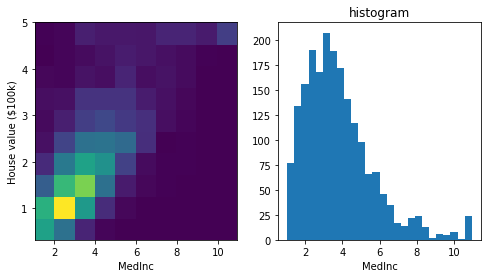

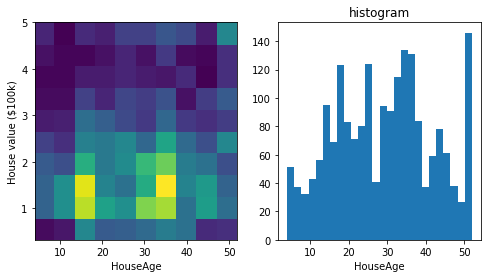

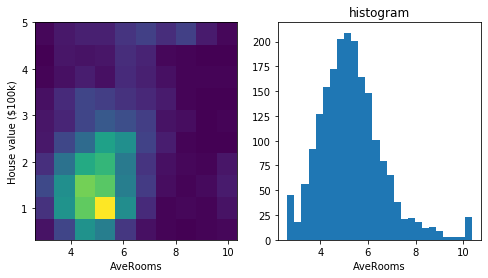

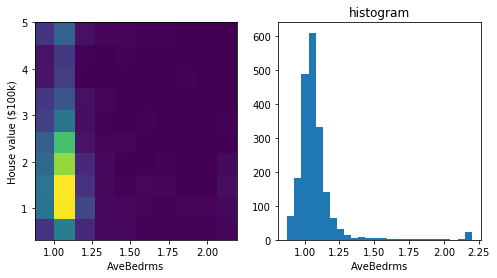

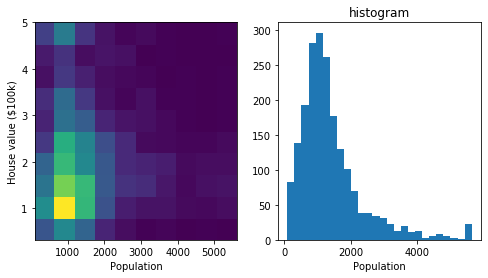

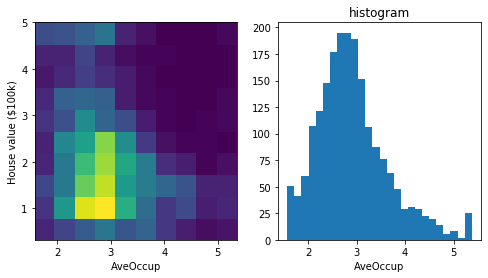

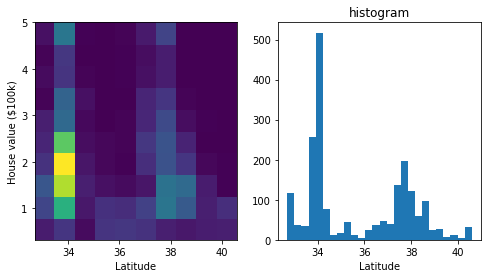

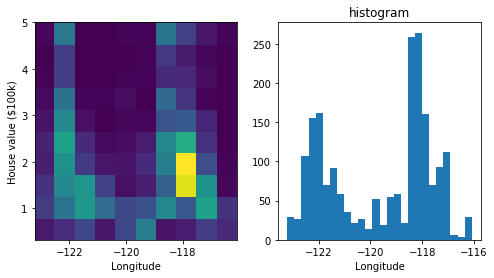

In [5]:
for col in x:
    fig,axs = plt.subplots(ncols=2, figsize=(8,4))
    axs[0].hist2d(x[col],y)
    axs[0].set_xlabel(col)
    axs[0].set_ylabel('House value ($100k)')
    axs[1].hist(x[col],bins='rice')
    axs[1].set_title('histogram')
    axs[1].set_xlabel(col)
    #plt.suptitle(col)
    plt.show()

In [6]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x,y,shuffle=True,train_size=0.70)
y_train = y_train.to_frame('y')
y_test = y_test.to_frame('y')

In [7]:
x_scaler = sklearn.preprocessing.StandardScaler()
y_scaler = sklearn.preprocessing.StandardScaler()

x_train = pd.DataFrame(x_scaler.fit_transform(x_train),index = x_train.index, columns = x_train.columns)
x_test =  pd.DataFrame(x_scaler.transform(x_test),index = x_test.index, columns = x_test.columns)
y_train = pd.DataFrame(y_scaler.fit_transform(y_train),index = y_train.index, columns = y_train.columns)
y_test =  pd.DataFrame(y_scaler.transform(y_test),index = y_test.index, columns = y_test.columns)

In [8]:
x_train = torch.tensor(x_train.values).float()
x_test = torch.tensor(x_test.values).float()
y_train = torch.tensor(y_train.values).float()
y_test = torch.tensor(y_test.values).float()

# NN setup

In [9]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, x,y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return {
            'x': self.x[idx,:],
            'y': self.y[idx,:],
        }

In [10]:
class SimpleNN(torch.nn.Module):
    def __init__(self,insize,linlayers):
        super(type(self),self).__init__()
        self.linlayers_size = linlayers
        self.layers=[]
        
        prev = insize
        for curlayersize in self.linlayers_size:
            self.layers.append(torch.nn.Linear(prev,curlayersize))
            self.layers.append(torch.nn.ReLU())
            prev = curlayersize
        self.layers.append(torch.nn.Linear(self.linlayers_size[-1],1,bias=True))
        self.layers = torch.nn.Sequential(*self.layers)
        
    def forward(self,x):
        x = self.layers(x)
        return x

In [11]:
for i in range(8,16,1):
    print(f"{i:>3}: {2**i:<5}, {x_train.shape[0]/(2**i):.1f} iter")

  8: 256  , 5.5 iter
  9: 512  , 2.7 iter
 10: 1024 , 1.4 iter
 11: 2048 , 0.7 iter
 12: 4096 , 0.3 iter
 13: 8192 , 0.2 iter
 14: 16384, 0.1 iter
 15: 32768, 0.0 iter


# Train Params

In [12]:
# LOSS

def L2Loss(model):
    return sum(p.pow(2.0).sum() for p in model.parameters())

# losses
Lfx = {
    0:torch.nn.MSELoss(),
    1:L2Loss,
}
L={
    0:None,
    1:None,
}
# loss weights
w = {
    0:1,
    1:1,
}
# boundary conditions (minimum weights)
c = {
    0:0.2,
    1:0.2,
}
grad = {
    0:[],
    1:[],
}

In [13]:
def pareto(w_in,c_in,G_in):
    G = G_in.numpy()
    K,M = G.shape
    c = np.expand_dims(np.array([c_in[i] for i in range(K)]),1)
    w = np.expand_dims(np.array([w_in[i] for i in range(K)]),1)
    #print(f"K: {K}")
    #print(f"M: {M}")
    #print(f"c: {c.shape}")
    #print(f"w: {w.shape}")
    
    # building e
    e = np.ones(w.shape)
    #print(f"e: {e.shape}")
    
    # building M
    GGT = np.matmul(G,G.T)
    #print(f"GGT: {GGT.shape}")
    
    m_top = np.hstack((GGT, e))
    m_bot = np.hstack((e.T, np.zeros((1,1))))
    M = np.vstack((m_top,m_bot))
    #print(f"GGT: {GGT.shape}")
    
    # building z
    z = np.vstack((-np.matmul(GGT,c),1-np.sum(c)))
    #print(f"z: {z.shape}")
    
    # building w_hat
    w_hat = np.linalg.inv(np.matmul(M.T,M)) #(MT * M)**-1
    w_hat = np.matmul(w_hat,M)
    w_hat = np.matmul(w_hat,z)
    w_hat = w_hat[1:]
    
    # at this point, w_hat could be negative, so we have to make them non-negative
    
    return w_hat
#w_hat = pareto(w,c,G)
#display(w_hat)

In [14]:
# from github page
def ASM(hat_w, c_in):
    """
    ref:
    http://ofey.me/papers/Pareto.pdf,
    https://stackoverflow.com/questions/33385898/how-to-include-constraint-to-scipy-nnls-function-solution-so-that-it-sums-to-1
    :param hat_w: # (K,)
    :param c: # (K,)
    :return:
    """
    
    #reformat c
    c = np.expand_dims(np.array([c_in[i] for i in range(2)]),1)
    
    A = np.array([[0 if i != j else 1 for i in range(len(c))] for j in range(len(c))])
    b = hat_w.squeeze()
    x0, _ = scipy.optimize.nnls(A, b)

    def _fn(x, A, b):
        return np.linalg.norm(A.dot(x) - b)

    cons = {'type': 'eq', 'fun': lambda x: np.sum(x) + np.sum(c) - 1}
    bounds = [[0., None] for _ in range(len(hat_w))]
    min_out = scipy.optimize.minimize(_fn, x0, args=(A, b), method='SLSQP', bounds=bounds, constraints=cons)
    new_w = min_out.x + c.squeeze()
    return new_w
#new_w_hat = ASM(w_hat, c)
#new_w_hat

In [15]:
model = SimpleNN(x_train.shape[1],[64])
model

SimpleNN(
  (layers): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [16]:
param={
    'batch_size':2**14,
    'epochs':2000,
    'optim':torch.optim.Adam(model.parameters(), 0.001),
}

In [17]:
dataset = CustomDataset(x_train,y_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=param['batch_size'], shuffle=True)

In [18]:
training={
    'train':{0:[],1:[]},
    'valid':{0:[],1:[]},
    'time':[],
    'w':{
        0:[],
        1:[],
    }
}

def NoneGrad(model):
    for i in model.parameters():
        i.grad=None
        

for e in range(param['epochs']):
    curtime = time.time()
    
    batchloss={0:[],1:[]}
    for b,batch in enumerate(dataloader):
        print(f"e: {e}; b: {b}",end='\r',flush=True)
        
        # -----train-----
        model.train()
        
        # zero out grad
        param['optim'].zero_grad()
        # predict
        y_hat = model.forward(batch['x'])
        # loss
        L[0] = Lfx[0](batch['y'],y_hat)
        L[1] = Lfx[1](model)
        # store loss individually for tracking purposes
        for i in Lfx:
            batchloss[i].append(L[i].detach())
        # gradients w.r.t. each loss
        for i in Lfx:
            L[i].backward(retain_graph=True)
            grad[i]=[j.grad for j in model.parameters()]
            NoneGrad(model)
        # flatten and stack grads, such that G = KxM where K = # of losses, M = total # of params
        G = torch.stack([torch.cat([i.flatten() for i in grad[j]]) for j in Lfx])
                
        # INSERT PARETO STEP HERE TO FIND w
        # pareto step
        w_hat = pareto(w,c,G)
        # constraints - non-neg, sum to 1
        new_w_hat = ASM(w_hat, c)
        # update w_hat
        for i in w:
            multi = 1
            if i==1: # manual weighting for L2 loss since scale is so different
                multi = 0.1
            w[i] = new_w_hat[i] * multi
            training['w'][i].append(new_w_hat[i])
            
        # backprop
        (sum([L[i]*w[i] for i in Lfx])).backward()
        
        # update
        param['optim'].step()
    for i in Lfx:
        training['train'][i].append(np.mean(batchloss[i]))
    
    # -----valid-----
    model.eval()
    
    y_test_hat = model.forward(x_test)
    
    L0_valid = Lfx[0](y_test,y_test_hat)
    L1_valid = Lfx[1](model)
    
    training['valid'][0].append(L0_valid.detach())
    training['valid'][1].append(L1_valid.detach())
    
    training['time'].append(time.time()-curtime)
    

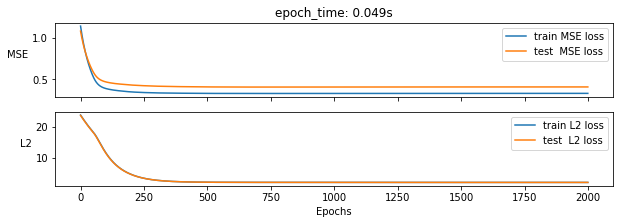

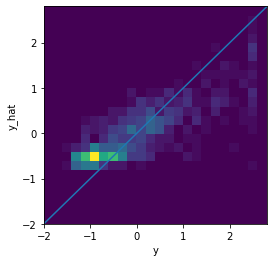

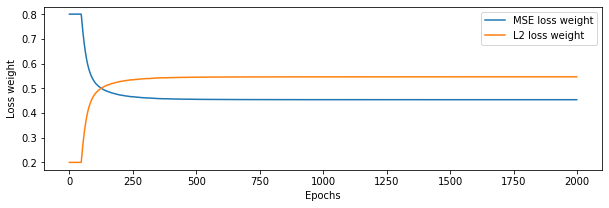

In [76]:
fig,axs = plt.subplots(nrows=2, figsize=(10,3),sharex=True)
axs[0].plot(training['train'][0],label='train MSE loss')
axs[0].plot(training['valid'][0],label='test  MSE loss')
axs[1].plot(training['train'][1],label='train L2 loss')
axs[1].plot(training['valid'][1],label='test  L2 loss')
axs[0].legend()
axs[1].legend()
axs[0].set_title(f"epoch_time: {np.mean(training['time']):.3f}s")
axs[0].set_ylabel('MSE',rotation=0,ha='right')
axs[1].set_ylabel('L2',rotation=0,ha='right')
axs[1].set_xlabel('Epochs')
plt.show()
                 
                 
fig,axs = plt.subplots(figsize=(4,4))
axs.hist2d(y_test.detach()[:,0].numpy(), y_test_hat.detach()[:,0].numpy(),bins = np.arange(-2,3,0.2))
axs.plot([-2,3],[-2,3])
axs.set_xlabel('y')
axs.set_ylabel('y_hat')
plt.show()
                 
fig,axs = plt.subplots(figsize=(10,3))
axs.plot(training['w'][0],label='MSE loss weight')
axs.plot(training['w'][1],label='L2 loss weight')
axs.set_ylabel('Loss weight')
axs.set_xlabel('Epochs')
axs.legend()
plt.show()